In [1]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np
import cv2
np.seterr(all='raise')

Populating the interactive namespace from numpy and matplotlib


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def nd(l):
    return np.array(l,dtype=float)
def Vis(U):
# Visualizing A Cluster
    img=U/U.max()
    img=(img*255).astype(int)
    plt.imshow(img,cmap='gray')
    plt.show()
def VisCrisp(U):
    img=(U==numpy.amax(U,axis=(0)))*255
    for Map in img:
        Vis(Map)

In [3]:
def normalizeImage(img):
    minPx,maxPx=img.min(),img.max()
    NormalizedImg = (img-minPx)/(maxPx-minPx)
    return NormalizedImg

In [4]:
from scipy.signal import convolve2d
def conv(Mat,ngb):
    if(ngb==0):
        return np.zeros(Mat.shape)
    ngbhd=2*ngb+1
    Filter=np.ones((ngbhd, ngbhd))
    Filter[ngb,ngb]=0
    Filter/=ngbhd**2 - 1
    for i in range(Mat.shape[0]):
        Mat[i]=convolve2d(Mat[i], Filter, mode='same', boundary='fill', fillvalue=0)
    return Mat

In [31]:
def getVar(X):
    n=X.size
    mean=X.sum()/n
    Var=np.power(X-mean,2)
    return Var.sum()/n

def randomVMatGen(clusters):
    #V is the Centroid matrix
    return np.random.rand(clusters)

def UpCen(U,K,x,Lambda,ngb):
    delta = float("0.1e-9")
    T1=K*x+Lambda*conv(K*x,ngb)
    T2=K+Lambda*conv(K,ngb)
    R1=(U*T1).sum(axis=(1,2) )
    R2=(U*T2).sum(axis=(1,2) )
    Result= (R1+delta)/(R2+delta)
    return Result

def getCentroids(X,U,K,Lambda,c,m,ngb):
    #U=1-sugenoNeg(U)
    V= UpCen(np.power(U,m),K,X,Lambda,ngb)
    return V

def d2(X,Y):
    return (np.power(X-Y,2))

def updateMatU(X,V,Var,Lambda,c,m,ngb):
    D2=d2(X[np.newaxis,:,:],V[:,np.newaxis,np.newaxis])  
    K=np.exp(-D2/Var)
    U=1-K+Lambda*np.power(conv(1-K,ngb),m)
    U=np.power(U,-1/(m-1))
    U=U/U.sum(axis=0)
    return [U,K]

In [27]:
def fcm(mu,m=2,c=4,Lambda=0.01,ngb=1,e=0.0001,maxIter=200):
    X=nd(mu)
    Var=getVar(X)
    V=randomVMatGen(c)
    ind=1
    U=zeros_like(X)
    while ind<maxIter:
        U_prev=U
        U,K=updateMatU(X,V,Var,Lambda,c,m,ngb)
        V=getCentroids(X,U,K,Lambda,c,m,ngb)
        if (np.absolute(U-U_prev)).max() < e:
            break
        ind+=1
    print(ind)
    return U,V    

In [28]:
def printImg(img):
    plt.imshow(img,cmap='gray')
    plt.show()
    
def GetImg(FileName):
    import os
    cwd = os.getcwd()
    img = cv2.imread(cwd+'\\Img\\'+FileName, cv2.IMREAD_GRAYSCALE)
    return img

def GetMap(U):
    Map=(U==numpy.amax(U,axis=(0))).astype(int)
    return Map

def GetGroundTurthMaps(FileName='NewImg2.tiff'):
    import os
    cwd = os.getcwd()
    img1 = GetImg(FileName)
    uniq=np.unique(img1)
    uniq.sort()
    Map=[]
    for i in range(uniq.size):
        Map.append(img1==uniq[i])
    return nd(Map),uniq,img1

def GetResMaps(res,getGrndTruth=0):
    img=GetImg('NewImg2.tiff')
    Maps=GetMap(res[0])
    Maps=nd(Maps)
    Avg=np.zeros(Maps.shape[0])
    for i in range(Maps.shape[0]):
        if Maps[i].sum() == 0:
            Avg[i]=0
        else:
            Avg[i]=(img*Maps[i]).sum()/Maps[i].sum()
    Ord=numpy.argsort(Avg)
    Maps=Maps[Ord]
    #Maps=Maps*Inten[:,np.newaxis,np.newaxis] #To get the colored resultant
    return Maps

In [29]:
def DiceScore(G,R):
    intersectionPx=2*(G*R).sum(axis=(1,2))
    return intersectionPx/(G+R).sum(axis=(1,2))
def AvgSegAcc(G,R):
    intersectionPx=(G*R).sum()
    return intersectionPx/G.sum()
def Scores(G,R):
    return DiceScore(G,R),AvgSegAcc(G,R)

def GetScores(FileName,G,printResMap=1):
    res=fcm(GetImg(FileName))
    R=GetResMaps(res)
    if printResMap:
        for seg in R:
            printImg(seg)
    return Scores(G,R)

def GetAllImgScores(printResMap=1):
    import os
    path = os.getcwd()+'\\Img'
    Files=os.listdir(path)
    G,a,b=GetGroundTurthMaps()
    FilesScr={}
    for file in Files:
        FilesScr[file]=GetScores(file,G,printResMap)
        print(FilesScr[file])
    return FilesScr

9


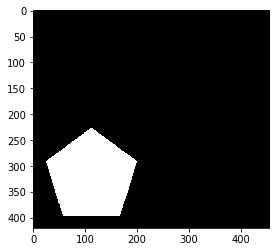

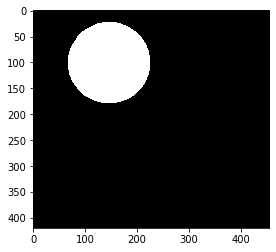

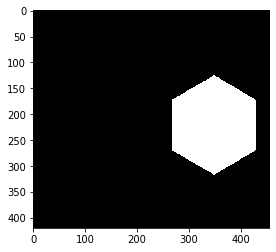

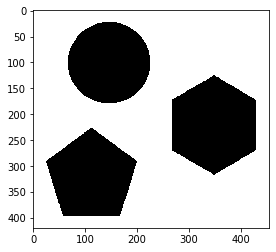

(array([1., 1., 1., 1.]), 1.0)
17


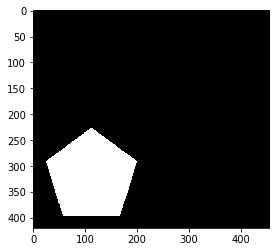

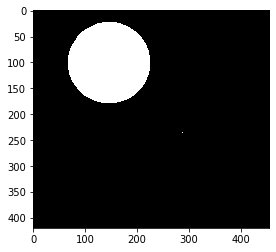

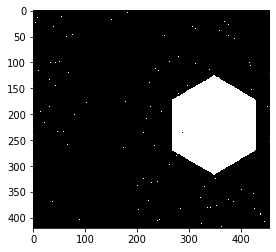

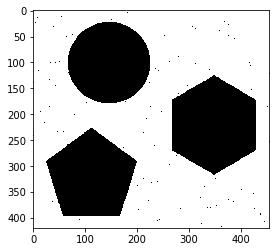

(array([1.        , 0.99997447, 0.99288702, 0.99869124]), 0.9982508354218881)
50


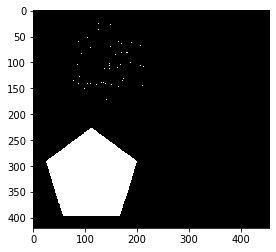

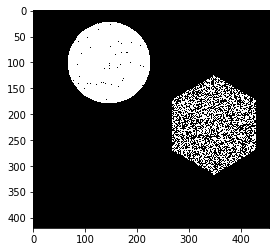

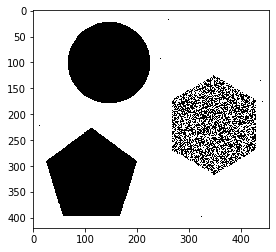

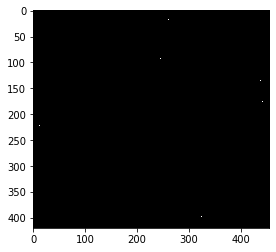

(array([9.95425698e-01, 7.58070820e-01, 1.37953128e-01, 4.85144409e-04]), 0.26840538847117795)
50


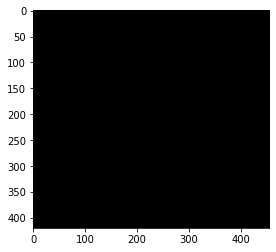

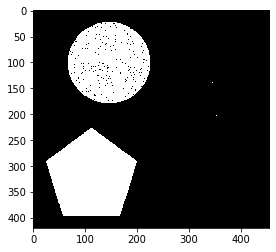

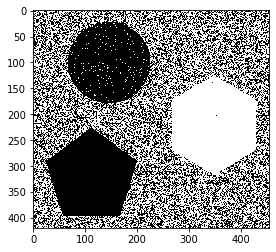

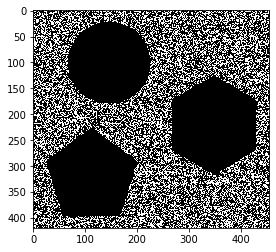

(array([0.        , 0.63650177, 0.3875113 , 0.59907789]), 0.5057383040935672)
50


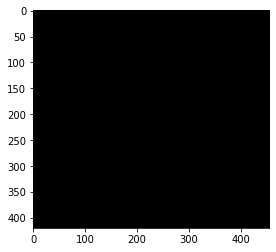

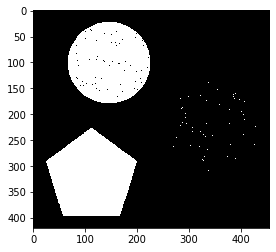

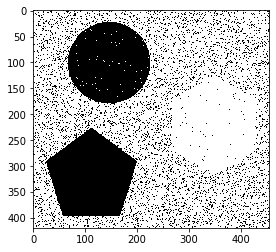

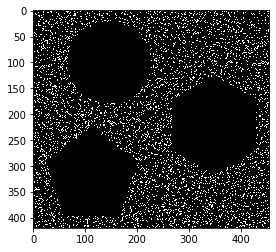

(array([0.        , 0.64520008, 0.29536902, 0.24172406]), 0.3136748120300752)


{'NewImg2.tiff': (array([1., 1., 1., 1.]), 1.0),
 'NewImg2_0_001.tiff': (array([1.        , 0.99997447, 0.99288702, 0.99869124]),
  0.9982508354218881),
 'NewImg2_0_002.tiff': (array([9.95425698e-01, 7.58070820e-01, 1.37953128e-01, 4.85144409e-04]),
  0.26840538847117795),
 'NewImg2_0_003.tiff': (array([0.        , 0.63650177, 0.3875113 , 0.59907789]),
  0.5057383040935672),
 'NewImg2_0_004.tiff': (array([0.        , 0.64520008, 0.29536902, 0.24172406]),
  0.3136748120300752)}

In [23]:
GetAllImgScores()

9


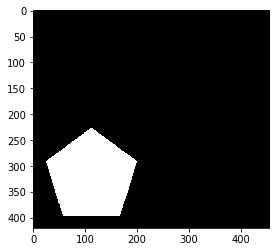

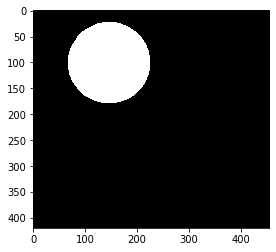

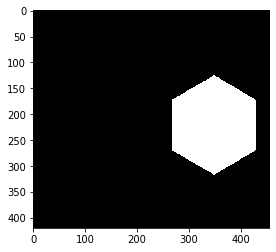

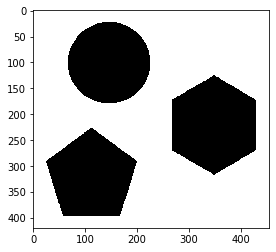

(array([1., 1., 1., 1.]), 1.0)
21


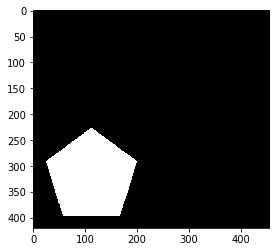

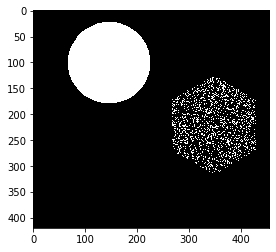

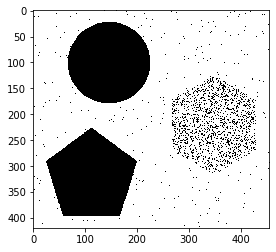

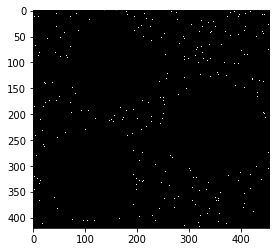

(array([0.99997594, 0.88636466, 0.2178643 , 0.01449895]), 0.3115340434419382)
200


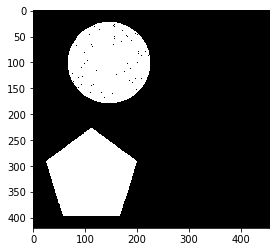

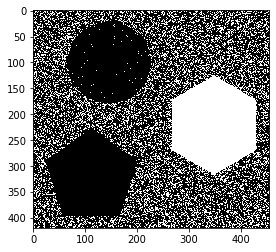

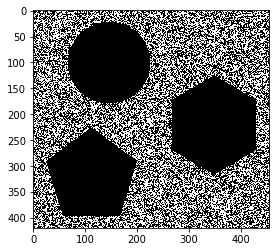

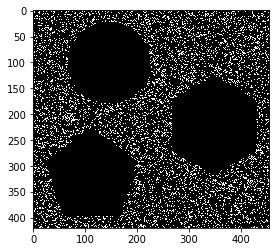

(array([0.6818577 , 0.0046573 , 0.        , 0.30471502]), 0.2294329573934837)
200


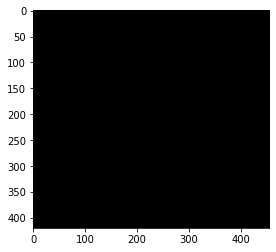

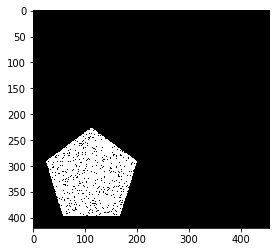

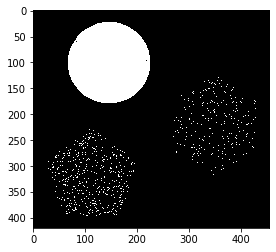

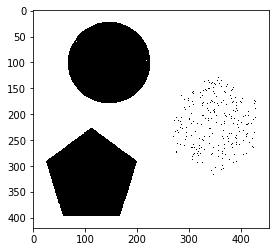

(array([0.00000000e+00, 5.17210168e-05, 4.04044835e-02, 9.19179856e-01]), 0.6719298245614035)
200


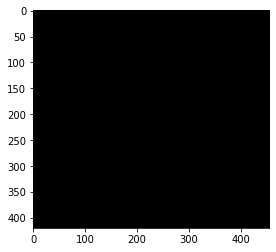

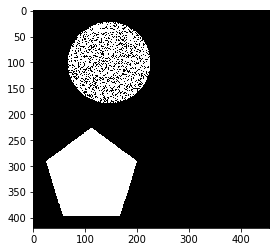

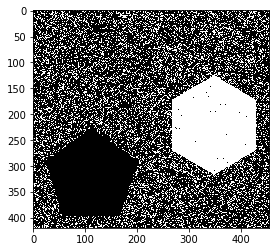

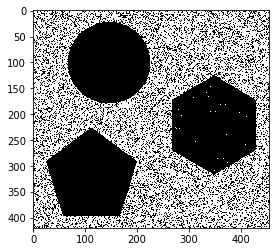

(array([0.        , 0.54008607, 0.55273366, 0.85155692]), 0.6946167502088555)


{'NewImg2.tiff': (array([1., 1., 1., 1.]), 1.0),
 'NewImg2_0_001.tiff': (array([0.99997594, 0.88636466, 0.2178643 , 0.01449895]),
  0.3115340434419382),
 'NewImg2_0_002.tiff': (array([0.6818577 , 0.0046573 , 0.        , 0.30471502]),
  0.2294329573934837),
 'NewImg2_0_003.tiff': (array([0.00000000e+00, 5.17210168e-05, 4.04044835e-02, 9.19179856e-01]),
  0.6719298245614035),
 'NewImg2_0_004.tiff': (array([0.        , 0.54008607, 0.55273366, 0.85155692]),
  0.6946167502088555)}

In [32]:
GetAllImgScores()

9


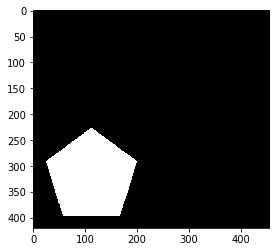

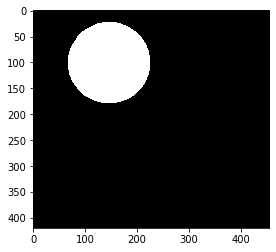

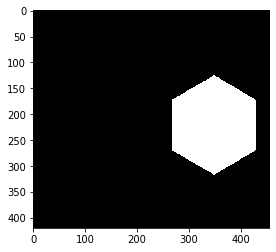

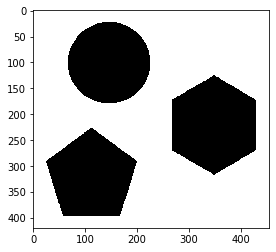

(array([1., 1., 1., 1.]), 1.0)
18


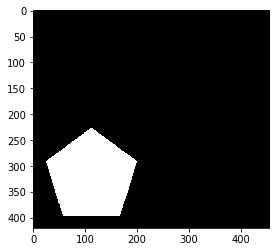

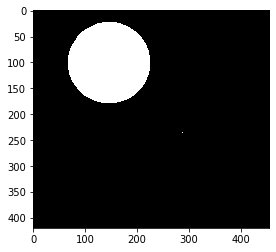

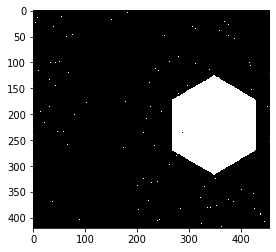

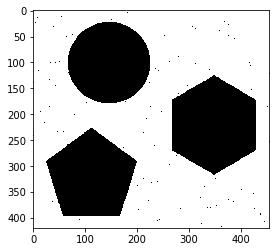

(array([1.        , 0.99997447, 0.99288702, 0.99869124]), 0.9982508354218881)
200


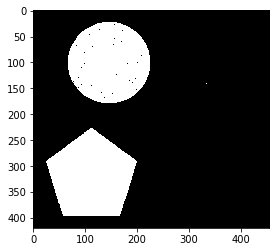

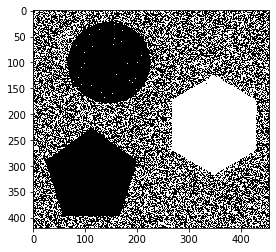

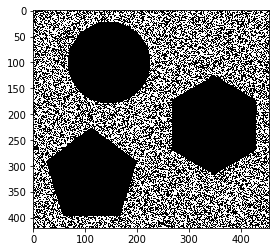

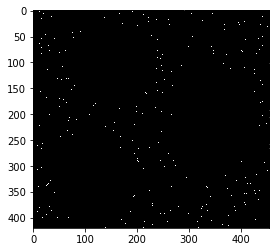

(array([0.68062947, 0.00169522, 0.        , 0.01238313]), 0.11311090225563909)
200


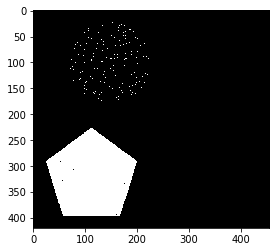

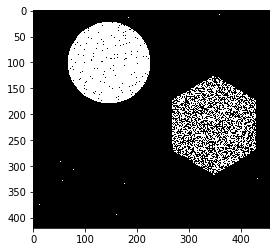

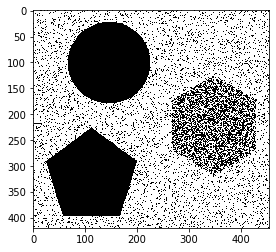

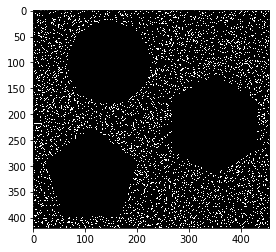

(array([0.98838925, 0.74176144, 0.1441773 , 0.20990837]), 0.34169277360066835)
200


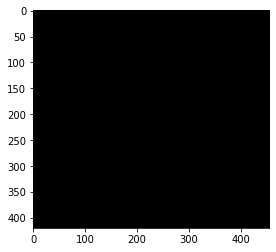

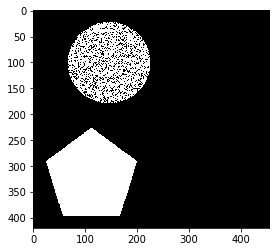

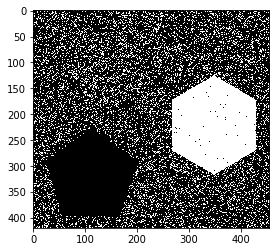

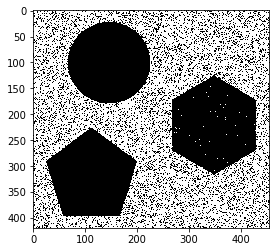

(array([0.        , 0.54005967, 0.60222306, 0.88682283]), 0.7313544277360067)


{'NewImg2.tiff': (array([1., 1., 1., 1.]), 1.0),
 'NewImg2_0_001.tiff': (array([1.        , 0.99997447, 0.99288702, 0.99869124]),
  0.9982508354218881),
 'NewImg2_0_002.tiff': (array([0.68062947, 0.00169522, 0.        , 0.01238313]),
  0.11311090225563909),
 'NewImg2_0_003.tiff': (array([0.98838925, 0.74176144, 0.1441773 , 0.20990837]),
  0.34169277360066835),
 'NewImg2_0_004.tiff': (array([0.        , 0.54005967, 0.60222306, 0.88682283]),
  0.7313544277360067)}

In [33]:
GetAllImgScores()